In [1]:
import yfinance as yf
import numpy as np
import pandas as pd

# Define the sample period as specified in the paper
start_date = "2000-07-03"
end_date = "2007-05-18"

# Download daily closing prices for NASDAQ (^IXIC) and TAIEX (^TWII)
data = yf.download(["^IXIC", "^TWII"], start=start_date, end=end_date)["Close"]
data.columns = ["NASDAQ", "TAIEX"]

# Drop any rows with missing values
data = data.dropna()

# Compute log returns in percentage format: r_t = 100 * ln(P_t / P_{t-1})
returns = 100 * np.log(data / data.shift(1))
returns = returns.dropna()

# Split the data into in-sample (first 1000 observations) and out-of-sample (remaining 639)
returns_in = returns.iloc[:1000]
returns_out = returns.iloc[1000:]

# Preview the first few rows of the computed returns
print("First 5 rows of log return data:")
print(returns.head())


C:\Users\rjx10\AppData\Local\Temp\ipykernel_10848\3471429483.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(["^IXIC", "^TWII"], start=start_date, end=end_date)["Close"]
[*********************100%***********************]  2 of 2 completed

First 5 rows of log return data:
              NASDAQ     TAIEX
Date                          
2000-07-05 -3.280481  1.482981
2000-07-06  2.491798 -1.584022
2000-07-07  1.568962 -1.413028
2000-07-10 -1.072290 -0.225509
2000-07-11 -0.601513  0.048549


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 NASDAQ   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2088.76
Distribution:                  Normal   AIC:                           4185.53
Method:            Maximum Likelihood   BIC:                           4205.16
                                        No. Observations:                 1000
Date:                Fri, Jun 27 2025   Df Residuals:                      999
Time:                        15:27:26   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.0205  5.702e-02      0.359      0.719 [-9.12

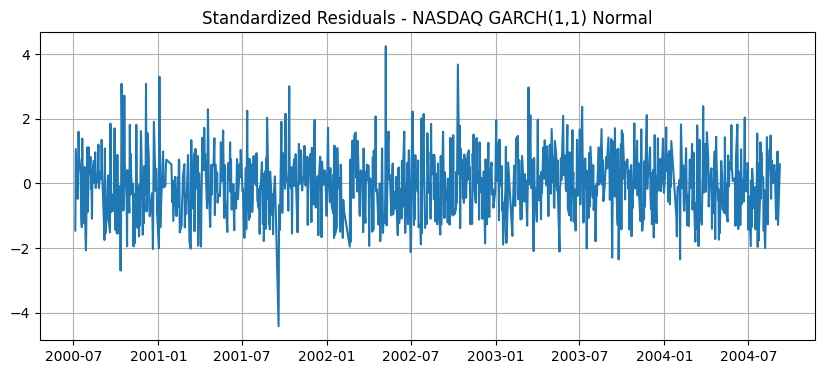


Ljung-Box test for standardized residuals:
     lb_stat  lb_pvalue
10  8.752101   0.555781


In [2]:
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

# Select NASDAQ in-sample return series
nasdaq_in = returns_in["NASDAQ"]

# Define a function to fit GARCH/GJR model
def fit_model(data, model_type="GARCH", dist="normal"):
    # Set distribution: 'normal' or 't'
    if dist == "normal":
        dist_type = "normal"
    elif dist == "t":
        dist_type = "t"
    else:
        raise ValueError("Distribution must be 'normal' or 't'")
    
    # Set volatility model: standard GARCH(1,1) or GJR-GARCH(1,1)
    if model_type == "GARCH":
        am = arch_model(data, vol="Garch", p=1, q=1, dist=dist_type, rescale=True)
    elif model_type == "GJR":
        am = arch_model(data, vol="GARCH", p=1, o=1, q=1, dist=dist_type, rescale=True)
    else:
        raise ValueError("Model type must be 'GARCH' or 'GJR'")
    
    # Fit the model
    res = am.fit(disp="off")
    return res

# Example: Fit GARCH-n (normal) model
garch_n_result = fit_model(nasdaq_in, model_type="GARCH", dist="normal")

# Print estimation results
print(garch_n_result.summary())

# Extract standardized residuals (used in copula fitting later)
std_resid = garch_n_result.std_resid

# Plot standardized residuals
plt.figure(figsize=(10, 4))
plt.plot(std_resid)
plt.title("Standardized Residuals - NASDAQ GARCH(1,1) Normal")
plt.grid(True)
plt.show()

# Ljung-Box test for autocorrelation in residuals (should not reject)
lb_test = acorr_ljungbox(std_resid, lags=[10], return_df=True)
print("\nLjung-Box test for standardized residuals:")
print(lb_test)

# Optional: Save residuals for copula fitting later
std_resid.name = "NASDAQ_GARCHn_resid"



==================== Estimating for NASDAQ ====================

--- Model: NASDAQ_GARCH_normal ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 NASDAQ   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2088.76
Distribution:                  Normal   AIC:                           4185.53
Method:            Maximum Likelihood   BIC:                           4205.16
                                        No. Observations:                 1000
Date:                Fri, Jun 27 2025   Df Residuals:                      999
Time:                        15:36:34   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
------------------------------------

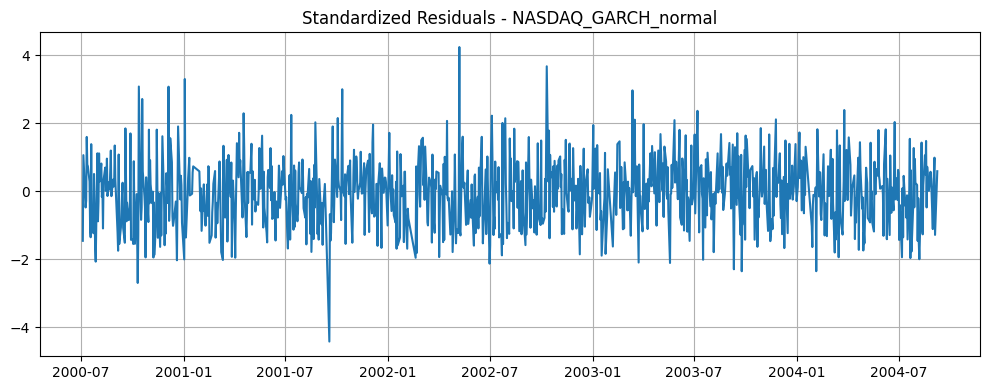


--- Model: NASDAQ_GARCH_t ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                       NASDAQ   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2086.51
Distribution:      Standardized Student's t   AIC:                           4183.03
Method:                  Maximum Likelihood   BIC:                           4207.57
                                              No. Observations:                 1000
Date:                      Fri, Jun 27 2025   Df Residuals:                      999
Time:                              15:36:34   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
----------------------------------------------------------

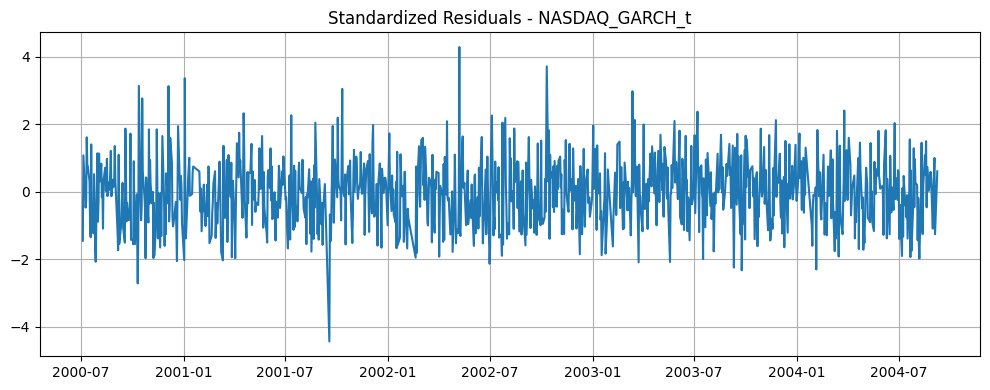


--- Model: NASDAQ_GJR_normal ---
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                 NASDAQ   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -2072.08
Distribution:                  Normal   AIC:                           4154.15
Method:            Maximum Likelihood   BIC:                           4178.69
                                        No. Observations:                 1000
Date:                Fri, Jun 27 2025   Df Residuals:                      999
Time:                        15:36:34   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0418  5.509e-

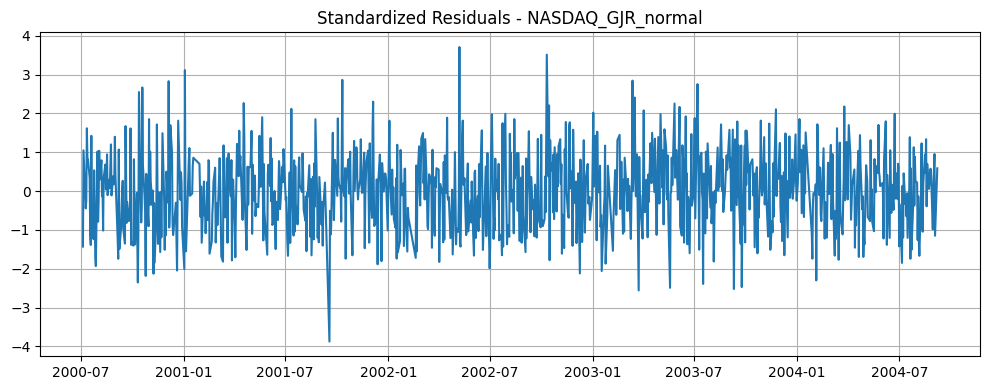


--- Model: NASDAQ_GJR_t ---
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                       NASDAQ   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -2071.91
Distribution:      Standardized Student's t   AIC:                           4155.82
Method:                  Maximum Likelihood   BIC:                           4185.27
                                              No. Observations:                 1000
Date:                      Fri, Jun 27 2025   Df Residuals:                      999
Time:                              15:36:34   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------

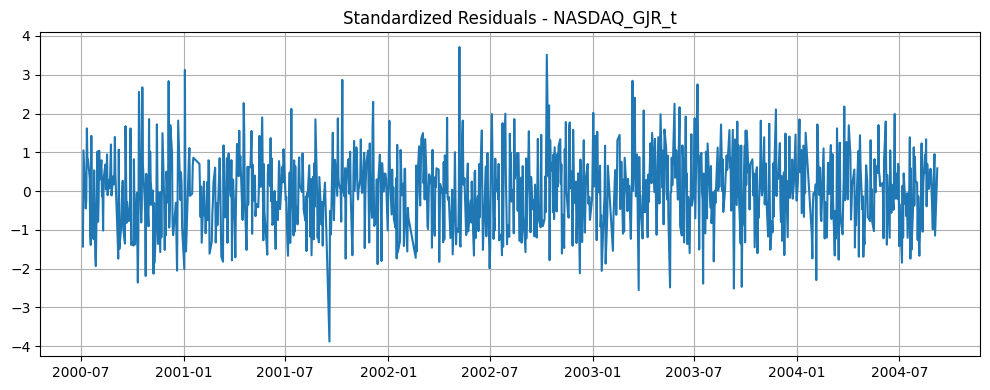


==================== Estimating for TAIEX ====================

--- Model: TAIEX_GARCH_normal ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  TAIEX   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2011.67
Distribution:                  Normal   AIC:                           4031.33
Method:            Maximum Likelihood   BIC:                           4050.97
                                        No. Observations:                 1000
Date:                Fri, Jun 27 2025   Df Residuals:                      999
Time:                        15:36:35   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
--------------------------------------

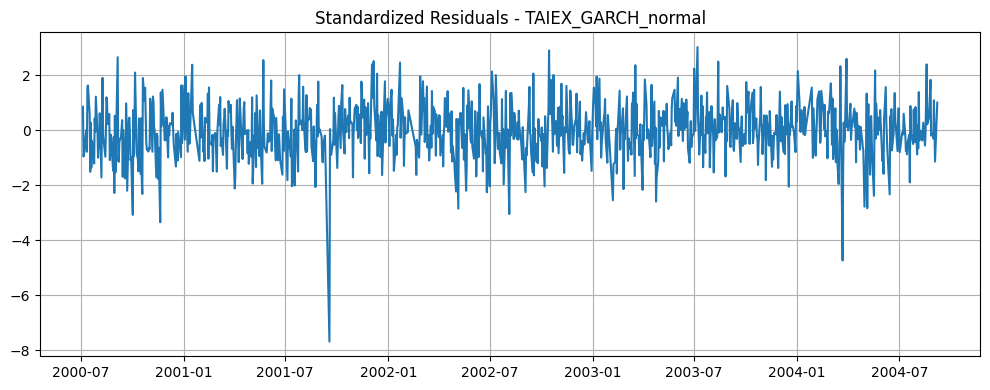


--- Model: TAIEX_GARCH_t ---
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        TAIEX   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1984.36
Distribution:      Standardized Student's t   AIC:                           3978.72
Method:                  Maximum Likelihood   BIC:                           4003.26
                                              No. Observations:                 1000
Date:                      Fri, Jun 27 2025   Df Residuals:                      999
Time:                              15:36:35   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
-----------------------------------------------------

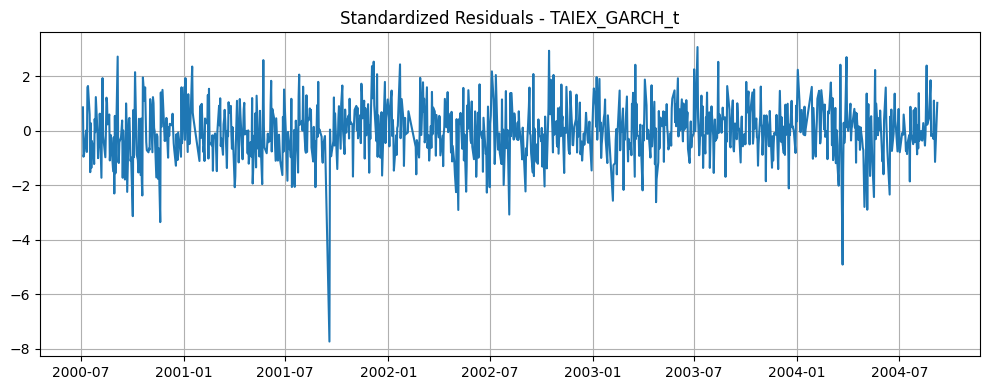


--- Model: TAIEX_GJR_normal ---
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                  TAIEX   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -2003.47
Distribution:                  Normal   AIC:                           4016.93
Method:            Maximum Likelihood   BIC:                           4041.47
                                        No. Observations:                 1000
Date:                Fri, Jun 27 2025   Df Residuals:                      999
Time:                        15:36:35   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu         2.7475e-03  5.290e-02  5.1

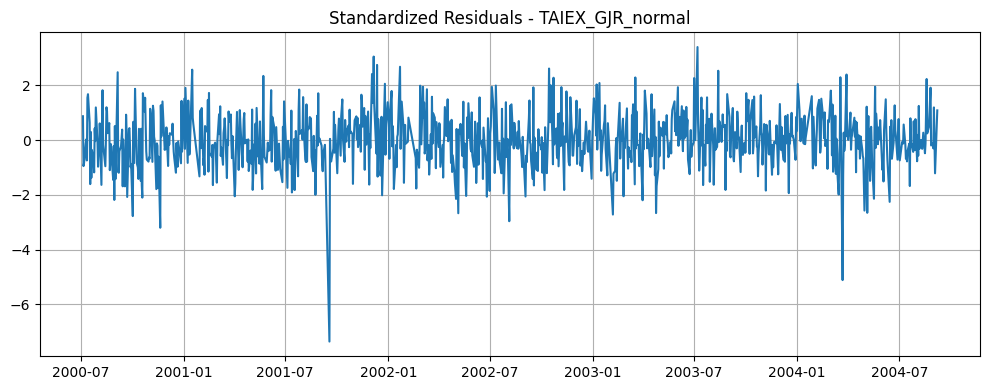


--- Model: TAIEX_GJR_t ---
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                        TAIEX   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -1978.58
Distribution:      Standardized Student's t   AIC:                           3969.15
Method:                  Maximum Likelihood   BIC:                           3998.60
                                              No. Observations:                 1000
Date:                      Fri, Jun 27 2025   Df Residuals:                      999
Time:                              15:36:35   Df Model:                            1
                                 Mean Model                                
                  coef    std err          t      P>|t|    95.0% Conf. Int.
-------------------------------------------------------

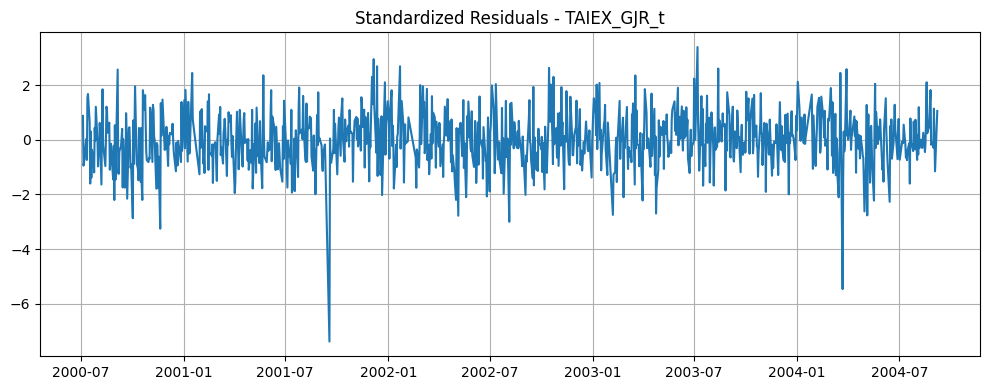

In [3]:
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

# Define model combinations
assets = ["NASDAQ", "TAIEX"]
models = ["GARCH", "GJR"]
distributions = ["normal", "t"]

# Store results and residuals
results_dict = {}
residuals_dict = {}

# Loop over each asset and model combination
for asset in assets:
    data_series = returns_in[asset]
    print(f"\n{'='*20} Estimating for {asset} {'='*20}")
    
    for model_type in models:
        for dist in distributions:
            model_name = f"{asset}_{model_type}_{dist}"
            print(f"\n--- Model: {model_name} ---")
            
            # Define model
            if model_type == "GARCH":
                am = arch_model(data_series, vol="Garch", p=1, q=1, dist=dist, rescale=True)
            elif model_type == "GJR":
                am = arch_model(data_series, vol="GARCH", p=1, o=1, q=1, dist=dist, rescale=True)
            else:
                continue
            
            # Fit model
            res = am.fit(disp="off")
            results_dict[model_name] = res
            
            # Print key statistics
            print(res.summary())
            print(f"AIC: {res.aic:.2f}, BIC: {res.bic:.2f}")
            
            # Standardized residuals
            std_resid = res.std_resid
            residuals_dict[model_name] = std_resid
            
            # Ljung-Box test
            lb_test = acorr_ljungbox(std_resid, lags=[10], return_df=True)
            print("\nLjung-Box test for standardized residuals (lag 10):")
            print(lb_test)
            
            # Plot residuals
            plt.figure(figsize=(10, 4))
            plt.plot(std_resid)
            plt.title(f"Standardized Residuals - {model_name}")
            plt.grid(True)
            plt.tight_layout()
            plt.show()


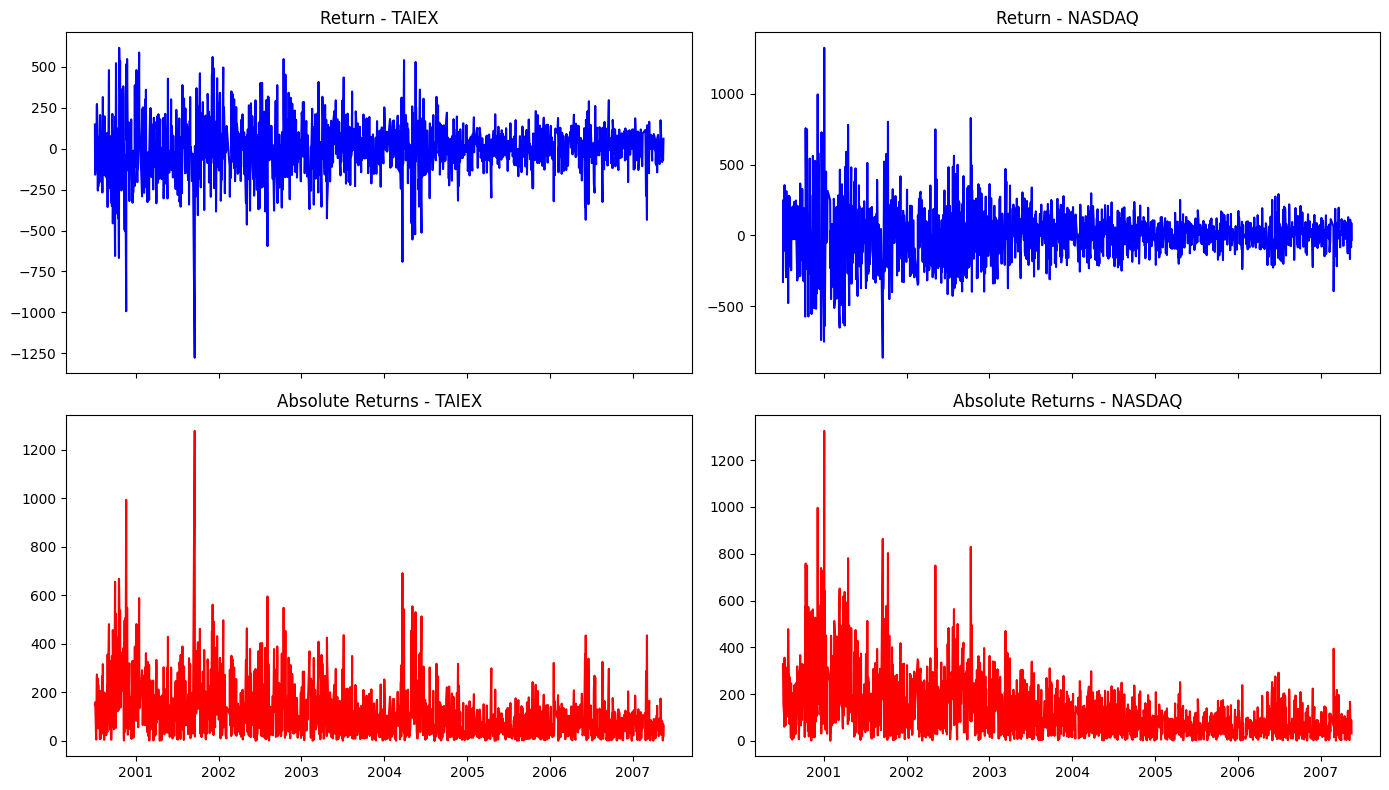

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare returns (from step 1)
returns_full = returns.copy()

# Plot settings
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

# Daily returns
axes[0, 0].plot(returns_full["TAIEX"] * 100, color='blue')
axes[0, 0].set_title("Return - TAIEX")
axes[0, 1].plot(returns_full["NASDAQ"] * 100, color='blue')
axes[0, 1].set_title("Return - NASDAQ")

# Absolute returns
axes[1, 0].plot(np.abs(returns_full["TAIEX"]) * 100, color='red')
axes[1, 0].set_title("Absolute Returns - TAIEX")
axes[1, 1].plot(np.abs(returns_full["NASDAQ"]) * 100, color='red')
axes[1, 1].set_title("Absolute Returns - NASDAQ")

plt.tight_layout()
plt.show()


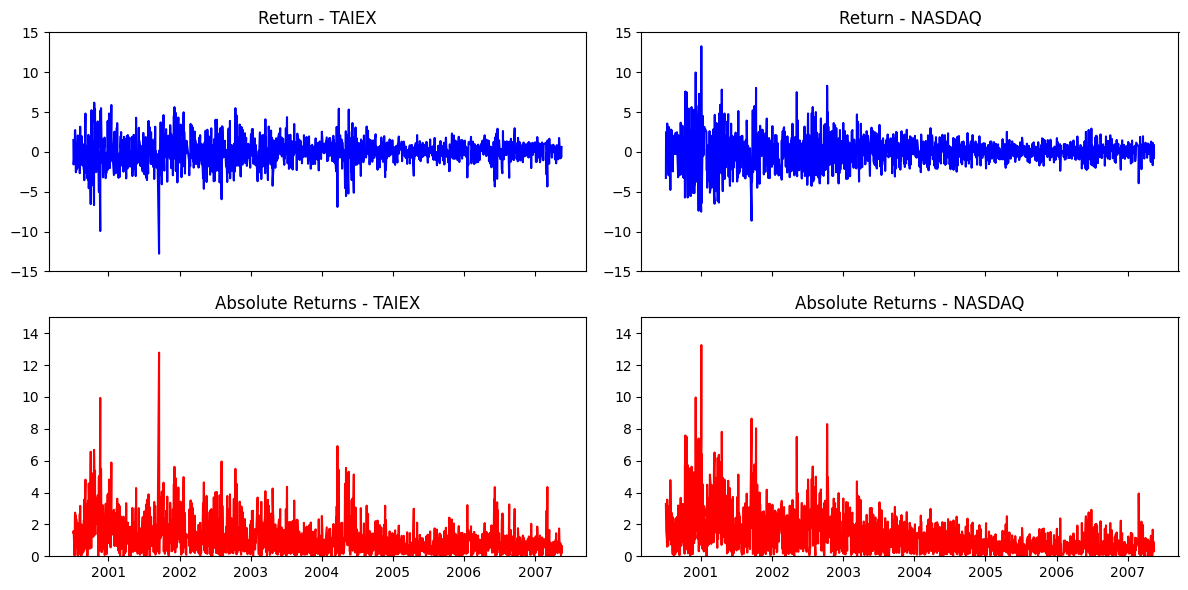

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Compute absolute returns
abs_returns = returns.abs()

# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)

# Top left: Return - TAIEX
axes[0, 0].plot(returns["TAIEX"], color='blue')
axes[0, 0].set_ylim(-15, 15)
axes[0, 0].set_title("Return - TAIEX")

# Top right: Return - NASDAQ
axes[0, 1].plot(returns["NASDAQ"], color='blue')
axes[0, 1].set_ylim(-15, 15)
axes[0, 1].set_title("Return - NASDAQ")

# Bottom left: Absolute Returns - TAIEX
axes[1, 0].plot(abs_returns["TAIEX"], color='red')
axes[1, 0].set_ylim(0, 15)
axes[1, 0].set_title("Absolute Returns - TAIEX")

# Bottom right: Absolute Returns - NASDAQ
axes[1, 1].plot(abs_returns["NASDAQ"], color='red')
axes[1, 1].set_ylim(0, 15)
axes[1, 1].set_title("Absolute Returns - NASDAQ")

# Layout adjustment
plt.tight_layout()
plt.show()


In [8]:
from scipy.stats import rankdata

# Select the GARCH-normal model residuals for both assets
resid_nasdaq = residuals_dict["NASDAQ_GARCH_normal"]
resid_taiex = residuals_dict["TAIEX_GARCH_normal"]

# Align the two series
aligned_resid = pd.concat([resid_nasdaq, resid_taiex], axis=1).dropna()
aligned_resid.columns = ["NASDAQ", "TAIEX"]

# Convert to pseudo-observations using empirical CDF (rank / (n+1))
u_nasdaq = rankdata(aligned_resid["NASDAQ"]) / (len(aligned_resid) + 1)
u_taiex = rankdata(aligned_resid["TAIEX"]) / (len(aligned_resid) + 1)

# Combine into matrix for copula fitting
u_data = np.column_stack([u_nasdaq, u_taiex])


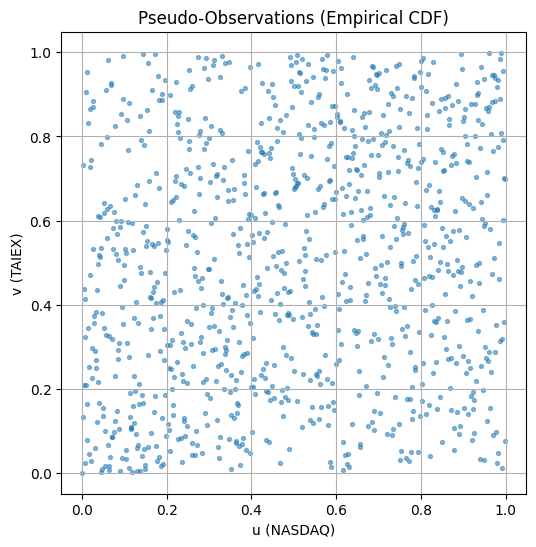

In [9]:
plt.figure(figsize=(6, 6))
plt.scatter(u_data[:, 0], u_data[:, 1], alpha=0.5, s=8)
plt.xlabel("u (NASDAQ)")
plt.ylabel("v (TAIEX)")
plt.title("Pseudo-Observations (Empirical CDF)")
plt.grid(True)
plt.show()


In [22]:
from scipy.stats import kendalltau
import numpy as np

# 假设 u_data 是 numpy.ndarray，shape = (N, 2)
tau, _ = kendalltau(u_data[:, 0], u_data[:, 1])

# t Copula 的 rho 估计：τ = (2/π) * arcsin(ρ)
rho = np.sin(np.pi * tau / 2)

print("Estimated Kendall's tau:", tau)
print("Estimated rho (for t Copula):", rho)


Estimated Kendall's tau: 0.1182102102102102
Estimated rho (for t Copula): 0.18461898000973392
